In [13]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')

import pymc as pm
import arviz as az

# import MH_inference
# import HMC_inference
from pyhf_pymc import prepare_inference


## Model

In [14]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 10],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None},
         {'name': 'mu1', 'type': 'normfactor', 'data': None}
        ]},

    {'name': 'background',
     'data': [550, 550, 550]
     ,
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.0],},
        {"name": "my_staterror1","type": "staterror","data": [2.0, 2.0, 2.0],},
        {"name": "my_staterror2","type": "staterror","data": [3.0, 3.0, 3.0],},
        ## Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [650, 560, 670], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [650, 506, 670], 'lo_data': [400, 400, 430]}},
        # {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [650, 560, 670], 'lo_data': [400, 400, 430]}},
        # ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        # {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 7.17]},
        # {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 8, 7.17]},
        # {'name': 'uncorr_bkg3', 'type': 'shapesys','data': [7, 8, 7.17]},
        # {'name': 'uncorr_bkg4', 'type': 'shapesys','data': [7, 8, 7.17]},
        # {'name': 'uncorr_bkg5', 'type': 'shapesys','data': [7, 8, 7.17]},
        
         ]
         },    
                                 
    ]},
    ]
    ,
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }],
        }
)

obs = model.expected_actualdata(model.config.suggested_init())

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[15], [1]]},
    'uncon2': {'type': 'unconstrained', 'type2': 'normal', 'input': [[15], [1]] }
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=1, priors=prior_dict)

In [15]:
with open('SRee_SRmm_Srem.json') as serialized:
# with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[2], [1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=1, priors=prior_dict)

## General functions

In [16]:
# Jax expected data
@jax.jit
def processed_expData(parameters):
    return model.expected_actualdata(parameters)

jitted_processed_expData = jax.jit(processed_expData)

# Gradient list (dn_bins/dx_1, ..., dn_bins/dx_nPars)
@jax.jit
def vjp_expData(pars, tang_vec):
    _, back = jax.vjp(processed_expData, pars)
    return back(tang_vec)[0]

jitted_vjp_expData = jax.jit(vjp_expData)

# jitted_processed_expData = jax.jit(processed_expData)
# jitted_vjp_expData = jax.jit(vjp_expData)


## Op Class

### Gradient Op

In [17]:
class VJPOp(Op):

    itypes = [pt.dvector,pt.dvector]  
    otypes = [pt.dvector]

    def perform(self, node, inputs, outputs):
        (parameters, tangent_vector) = inputs
        results = jitted_vjp_expData(parameters, tangent_vector)

        # if not isinstance(results, (list, tuple)):
        #         results = (results,)
                
        # for i, r in enumerate(results):
        #     outputs[i][0] = np.asarray(r)
        outputs[0][0] = np.asarray(results)

vjp_op = VJPOp()

## Non Gradient Op

In [18]:
class ExpDataOp(Op):

    itypes = [pt.dvector]  
    otypes = [pt.dvector]

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = jitted_processed_expData(parameters)

        # if len(outputs) == 1:
        #         outputs[0][0] = np.asarray(results)
        #         return
        # for i, r in enumerate(results):
        #         outputs[i][0] = np.asarray(r)
        outputs[0][0] = np.asarray(results)

    def grad(self, inputs, output_gradients):
        (parameters,) = inputs
        (tangent_vector,) = output_gradients
        return [vjp_op(parameters, tangent_vector)]

        
expData_op = ExpDataOp()

### Sampling

#### Metropolis

In [19]:
# %%timeit 
with pm.Model() as m:
    pars = pm.Deterministic('pars', prepare_inference.priors2pymc(prepared_model))
    ExpData_Det = pm.Deterministic('ExpData_Det', expData_op(pars))

    # ExpData = pm.Poisson("ExpData", mu=ExpData_Det, observed=obs)
    ExpData = pm.Normal("ExpData", mu=ExpData_Det, sigma = float(obs[0])**(0.5), observed=obs)
    
    step1 = pm.Metropolis()
    step2 = pm.NUTS()
    step3 = pm.HamiltonianMC()
    
    post_data = pm.sample(100, chains = 4, cores=4, step=step1)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]


Sampling: [ExpData, Normals, Unconstrained]


#### NUTS

In [20]:
# %%timeit
with pm.Model() as m1:
    pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    # ExpData1 = pm.Poisson("ExpData1", mu=ExpData_Det1, observed=obs)
    ExpData1 = pm.Normal("ExpData1", mu=ExpData_Det1, sigma = float(obs[0])**(0.5), observed=obs)
    
    # pm.init_nuts(init='advi')
    
    print('... pm.sample: ')
    post_data_test = pm.sample(100, chains=4, cores=4, init='advi')
    print('... pm.sample_porsterior_predictive: ')
    post_pred_test = pm.sample_posterior_predictive(post_data_test)
    print('... pm.sample_prior_predictive: ')
    prior_pred_test = pm.sample_prior_predictive(100)

Only 100 samples in chain.


... pm.sample: 


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Initializing NUTS using advi...


Convergence achieved at 35000
Interrupted at 34,999 [17%]: Average Loss = 7.4848e+06
Interrupted at 34,999 [17%]: Average Loss = 7.4848e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Unconstrained, Normals]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 73 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


... pm.sample_prior_predictive: 


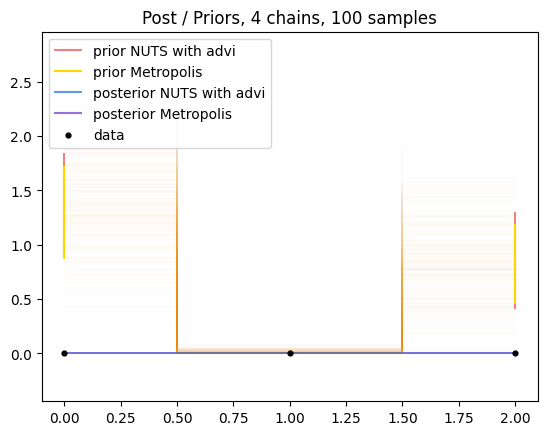

In [21]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_test.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'lightcoral', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_test.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'lightcoral', label='prior NUTS with advi');

plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.ExpData[0].T, alpha = 0.01, c = 'gold', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'gold', label='prior Metropolis');

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_test.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_test.posterior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='posterior NUTS with advi')

plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'mediumpurple', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'mediumpurple', label='posterior Metropolis')


# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Post / Priors, 4 chains, 100 samples')

# plt.savefig('Metropolis_adviNUsS_ttbar')
plt.show()

In [ ]:
az.plot_trace(prior_pred.prior, var_names='Unconstrained')
az.plot_trace(post_data.posterior, var_names='Unconstrained')

In [ ]:
fig = corner.corner(prior_pred.prior.Normals[0], hist_kwargs={'density': True}, color='green');
fig = corner.corner(post_data.posterior.Normals[0], fig = fig, color = 'steelblue', hist_kwargs={'density': True});